# The Secretary Problem

Faced with N candidates, a secretary must hire pick the best candidate. The secretary however, faces several complications:
<ol>
    <li> The candidates can only be interviewed one by one </li>
    <li> The candidates will be seen in a random order </li>
    <li> The candidate must be accepted or rejected immediately </li>
    <li> The candidates are only known by their cardinal rank, relative to all other candidates seen before them </li>
    <li> If no candidate has been selected by the end of the process, the final is selected</li>

This is quite a conundrum. 

First of all, the secretary is under a lot of pressure to pick the best candidate, anything less would constitute failure. Furthermore, there is a knowledge gap, whilst a candidate can be reviewed against all prior candidates, there's no knowing how they stand relative to the remaining candidates.

Can some maths clarify our position?

## Defining the Problem

Our secretary must work around a fundamental knowledge gap and make immediate decisions, with that in mind, is there any grounding that can be used to inform decisions?

##### Arbitrary Decisions

Consider our pool of candidates, in any given N-length list of candidates, the probability of any given candidate being the best is always P = 1/N. This does not bode well for the secretary hoping to pick a candidate at random.

In [1]:
import matplotlib.pyplot as plt
import random
import pandas as pd

In [2]:
def random_strategy(n: int, pool_len: list) -> int:
    pc = (1/pool_len)*100
    return pc

In [3]:
percentages = []
for i in range(1,101):
    result = random_strategy(1, i)
    percentages.append(result)

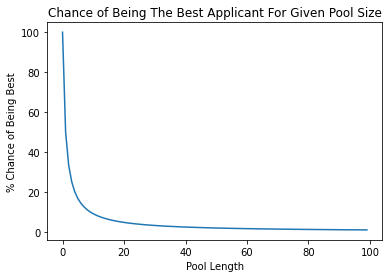

In [4]:
plt.plot(percentages)
plt.xlabel("Pool Length")
plt.ylabel("% Chance of Being Best")
plt.title("Chance of Being The Best Applicant For Given Pool Size");

Picking the Nth candidate at random is clearly not going to get the best candidate. Surely there are better strategies?

## Best of X Strategies

Assessing a candidate is hard, our secretary only knows their rank relative to previous candidates, not remaining candidates. However, with a bit of inspection we can glean more information:

Successive candidates are less and less likely to be the best seen thus far. Whilst it is not impressive for our first candidate to be the best seen so far, it is impressive for the 20th or 100th. 

The odds are $1/a_{x}$ for given candidate position, our first candidate has 1/1 odds of being the best candidate, our hundredth has 1/100 odds, much more impressive.

Armed with this knowledge we can generate a handful of strategies aimed at exploiting this.



#### Best of 2

Simply stated, we will pass over our first 'best' candidate and wait until the second time a candidate is ranked better than any previous. 

Practically speaking, this means skipping the first candidate. In a pool of 100 candidates how often do we find the winner?

In [5]:
def best_of_n(stop, pool_len, num_runs):
    successful_runs = 0
    
    for _ in range(num_runs):
        candidate_ord_pool = [*range(0,pool_len)]
        random.shuffle(candidate_ord_pool)
        
        best_candidate_counter = 0
        
        for i in candidate_ord_pool:
            try:
                if i <= min(candidate_ord_pool[:candidate_ord_pool.index(i)]):
                    best_candidate_counter += 1
                    if best_candidate_counter == stop:
                        if i == min(candidate_ord_pool):
                            successful_runs += 1
                        break
                else:
                    pass
            except ValueError:
                best_candidate_counter += 1
    
    success_rate = successful_runs / num_runs * 100
    return success_rate


    
    
    

In [61]:
def simulate_strategy(strategy, stop_nr, passes, pool_size):
    simulation_list = []
    
    for i in range(0, passes):
        x = strategy(stop = stop_nr, pool_len = pool_size, num_runs = passes)
        simulation_list.append(x)
        
    plt.plot(range(len(simulation_list)), simulation_list)
    plt.xticks([i for i, e in enumerate(simulation_list)])
    plt.locator_params(axis='x', nbins=10)
    plt.xlabel("simulation nr")
    plt.ylabel("Success rate")
    plt.title("Success Rate Distribution");
    
    raw = []
    for i in simulation_list:
        nr = passes * (i/100)
        raw.append(nr)


    overall_success_rate = round(sum(raw)/(len(simulation_list)*passes)*100,2)    
    print(f"Best candidate selected {overall_success_rate}% of the time")
    
    return simulation_list, overall_success_rate    
    

Best candidate selected 5.54% of the time


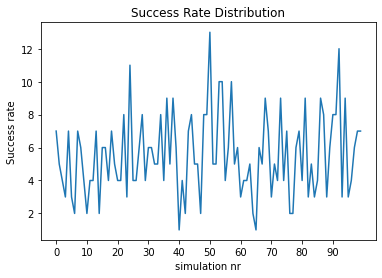

In [62]:
import numpy as np
first = simulate_strategy(best_of_n, stop_nr = 2, passes = 100, pool_size = 100)

At a glance, our success rate with 100 people reaches around 5.7%, this is better than with random picking, but still not close to a good approach. Let us demonstrate this strategy one more time, with more granularity.

Best candidate selected 5.21% of the time


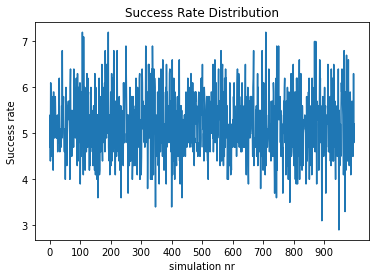

In [63]:
first = simulate_strategy(best_of_n, stop_nr = 2, passes = 1000, pool_size = 100)

Ran 1000 times, we have a more accurate picture of this strategy, reaching 5.21% from a pool of 100. As we are about to see things do not get any prettier, for any candidate pool size larger this strategy rapidly loses accuracy.

Best candidate selected 0.75% of the time


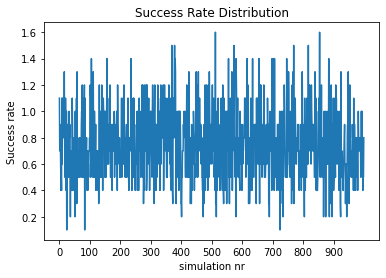

In [64]:
third = simulate_strategy(best_of_n, stop_nr = 2, passes = 1000, pool_size = 1000)

With a pool size of 1000, we can see the best candidate was selected only 0.75% of the time! This approach will surely cause problems for our secretary.

#### Takeaways 

It certainly is possible to tweak our 'best of x' strategy to get passable results - certainly better than randomly picking, but in fine tuning this approach we run into a major concern: <b>scaleability</b>, for candidate pools of small sizes, being too selective is detrimental, meanwhile at larger candidate pool sizes we must stop at some further 'best' candidate.

Armed with this knowledge, let us look at competing variants of this strategy across scaling candidate pools.

In [65]:
def run_simulations(stops, pool_lens, num_simulations):
    results = []
    
    for stop in stops:
        for pool_len in pool_lens:
            success_rates = []
            
            for i in range(num_simulations):
                success_rate = best_of_n(stop, pool_len, num_simulations)
                success_rates.append(success_rate)
            
            avg_success_rate = round(sum(success_rates) / num_simulations, 2)
            results.append([stop, pool_len, avg_success_rate])
    
    results_df = pd.DataFrame(results, columns=['Stop', 'Pool Length', 'Success Rate'])
    return results_df


In [66]:
def plot_success_rates(results_df):
    stop_values = sorted(results_df['Stop'].unique())
    colors = plt.cm.get_cmap('tab10')(stop_values)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, stop in enumerate(stop_values):
        stop_results = results_df[results_df['Stop'] == stop]
        ax.plot(stop_results['Pool Length'], stop_results['Success Rate'], label=f'Stop: {stop}', color=colors[i])
    
    ax.set_xlabel('Pool Length')
    ax.set_ylabel('Success Rate')
    ax.set_title('Secretary Problem Success Rates')
    ax.legend()
    
    plt.show()


In [68]:
df = run_simulations([2,4,8], [100,1000,10000], 100)

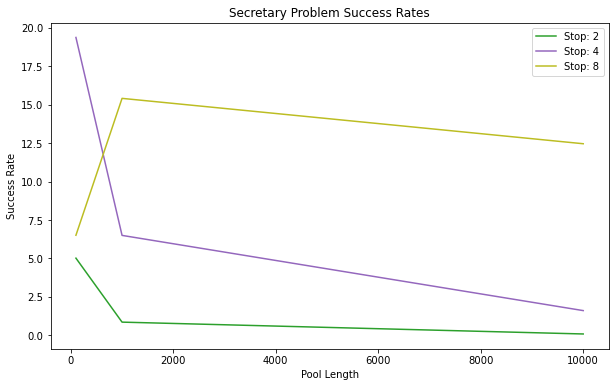

In [69]:
plot_success_rates(results_df = df)

These results are interesting, we can see that at lower candidate pools, some strategies are somewhat effective, with clear degradation over pool size. Let us now move on to our proper solution, and the subject of this paper.

### Explore Exploit Strategy

In [70]:
import math

In [82]:
def thirty_seven_percentage_strategy(pool_len, num_runs):

    # Generate a pool of candidates, number = ordinal rank, shuffle
    candidate_ord_pool = [*range(0,pool_len)]
    random.shuffle(candidate_ord_pool)

    threshold_index = math.ceil(0.37 * pool_len)

    candidates_seen = 0
    best_candidate_index = None
    successes = 0
    failures = 0

    best_before_threshold = min(candidate_ord_pool[:threshold_index])
    for i in range(num_runs):
        for i in candidate_ord_pool[threshold_index:]:
            if i < best_before_threshold:
                if i == min(candidate_ord_pool):
                    successes += 1
                    break
                else:
                    break
        
    return round((successes/num_runs)*100,2)




In [83]:
wins37 = []
for i in range(10000):
    wins37.append(thirty_seven_percentage_strategy(100,3))

In [89]:
print(wins37.count(100.0)/len(wins37)*100)

36.95


This solution solves our scalability issue, as pool sizes increases the solution remains consistent at around 37%. 

The solution qualifies our quandry as an optimal stopping problem. The proceedure being we are looking to spend some percentage of our candidate pool as a means to calibrate (ie reject) no matter their scoring. Crucially, of the remaining candidate pool we take the first to exceed the best found within the calibration section.




The outstanding result here is precisely that at arbitrarily large candidate pools we see the same success rate! 

Euler's Number & The 1/e Law

Eulers number (approximately 2.71828) is typically present in problems related to exponential growth or decay. 
In our case, we can see for any given N of e candidates the chance of them being the best candidate seen thus far decreases. As a quick reminder let's take a look at that below:

In [ ]:
N = 5

probabilities = [1/(i+1) for i in range(N)]
df = pd.DataFrame({
    'Candidate': list(range(1, N+1)),
    'Probability_Best_So_Far': probabilities
})

print(df)

For each candidate (e) seen, the probability of them being the best seen is 1/(e)
However if we reject some k candidates the probability of finding the best candidate becomes:

$$
\frac{{N-k}}{N} \times \frac{{k}}{N-1} \times \frac{{k-1}}{N-2} \times \ldots \times \frac{1}{N-k+1}
$$


When expanded, we can see that for any large N, the probability maximises at K≈N/e. At it's heart, we are seeing a steady growth of information, for each candidate we reject we get a further calibration of our assessment. 
Our optimal stopping point thus becomes a balance of the two factors discussed earlier:

1. Waiting too long, at which the probability of finding the best candidate diminishes desspite our information growth.
2. Not waiting long enough, at which point we have not gathered enough information to make an optimal choice.



Derivation

Exploration

As a matter of interest the following code should allow for the user to play with different stopping positions.

In [ ]:
import math
import random
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

def run_strategy(threshold, pool_len=100, num_runs=1000):
    successes = 0
    
    for _ in range(num_runs):
        candidate_ord_pool = list(range(pool_len))
        random.shuffle(candidate_ord_pool)

        threshold_index = math.ceil(threshold * pool_len)
        best_before_threshold = min(candidate_ord_pool[:threshold_index])

        for i in candidate_ord_pool[threshold_index:]:
            if i < best_before_threshold:
                if i == min(candidate_ord_pool):
                    successes += 1
                    break
                    
    success_rate = (successes / num_runs) * 100
    return success_rate

def plot_success_rate(threshold):
    success_rate = run_strategy(threshold)
    plt.figure(figsize=(10, 6))
    plt.bar(["Success Rate"], [success_rate], color='blue')
    plt.ylim(0, 100)
    plt.ylabel('Success Rate (%)')
    plt.title(f"Success Rate for Threshold = {threshold}")
    plt.show()
    
    print(f"Success rate: {success_rate}%")

threshold_slider = widgets.FloatSlider(value=0.37, min=0, max=1, step=0.01, description="Threshold:")
interact(plot_success_rate, threshold=threshold_slider);


: 

Real World Application

The application of optimal stopping problems extends far beyond curious mathematics as the problem deals with the very real life scenario of limited progressing information, and some limitation. Optimising to find the best decision can be seen in the world of [Finance](https://www.investopedia.com/terms/b/blackscholes.asp#:~:text=The%20Black%2DScholes%20model%2C%20aka,free%20rate%2C%20and%20the%20volatility.) with option trading. [Supply chain management](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.1120.1551) for vendor selection, and naturally [HR](https://www.researchgate.net/publication/277090022_Optimal_Stopping_for_Dynamic_Recruitment_Problem_with_Probabilistic_Loss_of_Candidates) for both candidate selection and candidate dropoff.


In addition to business contexts the mathematics herein have been popularised as a paradigm for personal decision making, from house hunting to dating.